In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import morton
import math
from hilbertcurve.hilbertcurve import HilbertCurve

In [2]:
# Create 2D data
df = pd.DataFrame(np.random.randint(0,64,size=(50, 2)), columns=list('AB'))
df.describe()

,A,B
count,50.000000,50.000000
mean,36.560000,29.100000
std,18.109824,20.428322
min,0.000000,0.000000
25%,23.250000,10.250000
50%,39.000000,26.500000
75%,51.750000,47.250000
max,62.000000,63.000000


In [3]:
# Morton algorithm
m = morton.Morton(dimensions=2, bits=64)
def set_value(data,key1,key2):    
    return m.pack(int(data[key1]), int(data[key2]))



In [4]:
hilbert_curve = HilbertCurve(64, 2, n_procs=-1)
def set_value_Hcurve(data,key1,key2,key3):
    points = data[[key1,key2]].to_numpy()
    distances = hilbert_curve.distances_from_points(points)
    data[key3] = pd.DataFrame(distances )
    return data

In [9]:
# Offset experiment asymetric
offset_1 = 0
offset_2 = 64
offset_3 = 256
df['A_offset_2']=df['A'].add(offset_1)
df['B_offset_2']=df['B'].add(offset_1)
df['A_offset_3']=df['A'].add(offset_2)
df['B_offset_3']=df['B'].add(offset_3)
df['morton_offset_2']= df.apply(set_value,args=('A_offset_2','B_offset_2'),axis=1)
df['morton_offset_3']= df.apply(set_value,args=('A_offset_3','B_offset_3'),axis=1)
df['offset_delta']=df['morton_offset_3']-df['morton_offset_2']
df['offset_delta']
df['offset_delta'].describe()
# plt.hist(df['offset_delta'],bins=10)


count        50.0
mean     135168.0
std           0.0
min      135168.0
25%      135168.0
50%      135168.0
75%      135168.0
max      135168.0
Name: offset_delta, dtype: float64

In [361]:
offset_2 = 0
offset_3 = 384 
df['A_offset_2']=df['A'].add(offset_2)
df['B_offset_2']=df['B'].add(offset_2)
df['A_offset_3']=df['A'].add(offset_3)
df['B_offset_3']=df['B'].add(offset_3)
df=set_value_Hcurve(df,'A_offset_2','B_offset_2','hcurve_offset_2')
df=set_value_Hcurve(df,'A_offset_3','B_offset_3','hcurve_offset_3')
df['offset_delta_hcurve']=df['hcurve_offset_3']-df['hcurve_offset_2']
df['offset_delta_hcurve']
df['offset_delta_hcurve'].describe()

# 3k*2^n where 2^n>max(df) for hilbert curve offset

count         5.0
mean     163840.0
std           0.0
min      163840.0
25%      163840.0
50%      163840.0
75%      163840.0
max      163840.0
Name: offset_delta_hcurve, dtype: float64

In [ ]:
df

/var/folders/fm/z_773gfs2d3cd8ch6mq3_s3r0000gn/T/ipykernel_79318/862714311.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


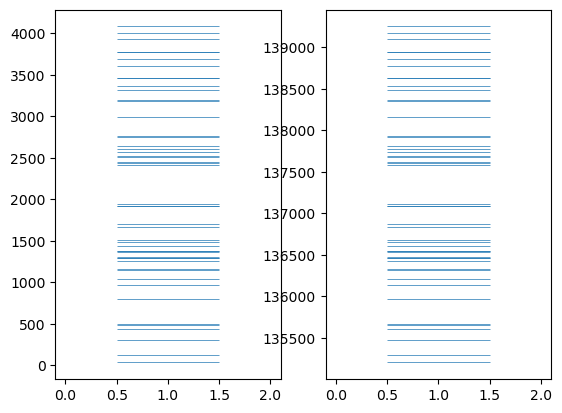

In [10]:
fig,ax=plt.subplots(1,2)
ax[0].eventplot(df['morton_offset_2'],orientation='vertical',linewidths=0.5)
ax[1].eventplot(df['morton_offset_3'],orientation='vertical',linewidths=0.5)
fig.show()

In [ ]:
# conclusion: for lowest 2^n>max(df), offset k*2^n will keep the shape of the CSP

In [ ]:
# Multiplier experiment
multi_2 = 1
multi_3 = 8
df['A_multi_2']=df['A'].multiply(multi_2)
df['B_multi_2']=df['B'].multiply(multi_2)
df['A_multi_3']=df['A'].multiply(multi_3)
df['B_multi_3']=df['B'].multiply(multi_3)
df['morton_multi_2']= df.apply(set_value,args=('A_multi_2','B_multi_2'),axis=1)
df['morton_multi_3']= df.apply(set_value,args=('A_multi_3','B_multi_3'),axis=1)
df['multi_delta']=df['morton_multi_3']/df['morton_multi_2']
df['multi_delta']
df['multi_delta'].describe()
# plt.hist(df['offset_delta'],bins=10)

In [ ]:
# Multiplier experiment h-curve
multi_2 = 1
multi_3 = 30
df['A_multi_2']=df['A'].multiply(multi_2)
df['B_multi_2']=df['B'].multiply(multi_2)
df['A_multi_3']=df['A'].multiply(multi_3)
df['B_multi_3']=df['B'].multiply(multi_3)
df=set_value_Hcurve(df,'A_multi_2','B_multi_2','hcurve_multi_2')
df=set_value_Hcurve(df,'A_multi_3','B_multi_3','hcurve_multi_3')
df['morton_multi_2']= df.apply(set_value,args=('A_multi_2','B_multi_2'),axis=1)
df['morton_multi_3']= df.apply(set_value,args=('A_multi_3','B_multi_3'),axis=1)
df['multi_delta_hcurve']=df['hcurve_multi_3']/df['hcurve_multi_2']
print(df)
df['multi_delta_hcurve'].describe()
# plt.hist(df['offset_delta'],bins=10)

In [ ]:
def get_std_with_different_multiplier(data,key1,key2,multiplier):
    col_name_1=key1+'_'+str(multiplier)
    col_name_2=key2+'_'+str(multiplier)
    data[col_name_1]=data[key1].multiply(multiplier)
    data[col_name_2]=data[key2].multiply(multiplier)
    data=set_value_Hcurve(data,col_name_1,col_name_2,'hcurve_multi')
    data=set_value_Hcurve(data,key1,key2,'origin')
    data['multi_delt_hcurve']=df['hcurve_multi']/df['origin']
    return data['multi_delt_hcurve'].std()


In [ ]:
std_list=[]
for i in range(2,100):
    std_list.append(get_std_with_different_multiplier(df,'A','B',i))
dff=pd.DataFrame(std_list,columns=['std'])
dff
# multiplier does not work with the h-curve

In [ ]:
dff.min()

In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].eventplot(df['morton_multi_2'],orientation='vertical',linewidths=0.5)
ax[1].eventplot(df['morton_multi_3'],orientation='vertical',linewidths=0.5)
fig.show()

In [ ]:
# Conclusion: multipler should be 2^n

In [ ]:
# Does Multiply and offset order matter Experiment: Answer yes! the order matters


In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].eventplot(df['morton_multi_2'],orientation='vertical',linewidths=0.5)
ax[1].eventplot(df['morton_multi_3'],orientation='vertical',linewidths=0.5)
fig.show()